In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
from sklearn.preprocessing import QuantileTransformer 
from sklearn.metrics import mean_squared_error as mse
normalizer = QuantileTransformer(output_distribution='normal')


In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of

def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    return b

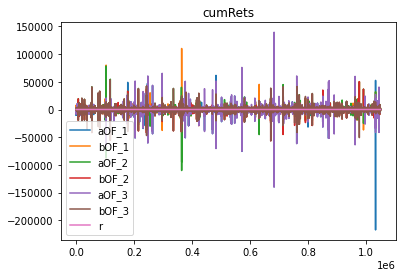

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)
C= int(len(lob_data))
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].pct_change()#diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data.plot()
plt.title('cumRets')
plt.show()

In [4]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))

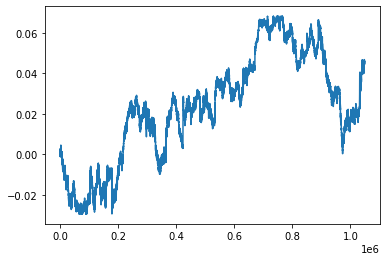

In [5]:
offlo['r'].plot();

In [17]:


y=                                                  offlo['r'][:-2].to_numpy()
x=    offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-2].to_numpy()
xFcst=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][-2:].to_numpy()
yFcst=                                              offlo['r'][-3:].to_numpy()

mdl = NARX(LinearRegression(), auto_order=1, exog_order=[100,100,100,100,100,100])
mdl.fit(x,y)
y_forecast = mdl.forecast(x, y, step=3, X_future=xFcst)
y_forecast,yFcst

(array([0.04463849, 0.0446372 , 0.04463907]),
 array([0.04470889, 0.0446559 , 0.0446559 ]))

In [25]:
uai=float(yFcst[2])
uai

0.044655903842737654

In [24]:
rBar=[of_data['r'][-1:].mean()]*len(y_forecast)
rBar

[0.044655903842737654, 0.044655903842737654, 0.044655903842737654]

In [ ]:
#(mse(yFcst,rBar)-mse(y_pred= y_forecast,y_true=yFcst))/mse(yFcst,rBar)

In [19]:
num=(yFcst-y_forecast)**2
den=(yFcst-rBar)**2
r2OutS=((den-num)/den)#/100#+0.1
r2OutS


C:\Users\macri\AppData\Local\Temp\ipykernel_7192\4250745161.py:3: RuntimeWarning: divide by zero encountered in true_divide
  r2OutS=((den-num)/den)#/100#+0.1


array([-0.76546221,        -inf,        -inf])

In [11]:
r2OutS

array([-inf, -inf])

In [14]:
help(plt.ylabel)

Help on function ylabel in module matplotlib.pyplot:

ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)
    Set the label for the y-axis.
    
    Parameters
    ----------
    ylabel : str
        The label text.
    
    labelpad : float, default: :rc:`axes.labelpad`
        Spacing in points from the Axes bounding box including ticks
        and tick labels.  If None, the previous value is left as is.
    
    loc : {'bottom', 'center', 'top'}, default: :rc:`yaxis.labellocation`
        The label position. This is a high-level alternative for passing
        parameters *y* and *horizontalalignment*.
    
    Other Parameters
    ----------------
    **kwargs : `.Text` properties
        `.Text` properties control the appearance of the label.
    
    See Also
    --------
    text : Documents the properties supported by `.Text`.



In [10]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
y=of_data['r'][:-1].to_numpy()
x=of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-1].to_numpy()
fcstX=of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][-1:].to_numpy()
fcstY=of_data['r'][-1:].to_numpy()

In [ ]:
#fa dataset
y=offlo['r'].to_numpy()
idx=10000
r=np.empty((idx,10))
med=np.empty((idx,10))
h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(10),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
        med[i][ii]=np.mean(y[:i+iii])

x_vec=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6,1)
erre=r
r.shape, x_vecc.shape,med.shape

((10000, 10), (10000, 100, 6, 1), (10000, 10))

In [ ]:
y=r[:-1]
x=of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-1].to_numpy()
x,y

(array([[    0.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.],
        ...,
        [  -56.,   -63.,   -63.,     0.,   -10.,     0.],
        [  227., -1523.,  1523.,  -200.,     0., -1032.],
        [    0.,  -300.,  -300.,     0.,     0.,     0.]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  3.31473399e-04, ...,
          0.00000000e+00,  5.52455665e-05,  0.00000000e+00],
        [-5.52577775e-05,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.76304156e-04,  0.00000000e+00,  0.00000000e+00, ...,
          5.52516714e-05, -5.52425146e-05, -1.65727544e-04],
        ...,
        [-5.56792873e-05, -5.56297285e-05,  1.11259457e-04, ...,
          5.56297285e-05,  0.00000000e+00,  0.00000000e+00],
        [ 5.56916908e-05,  5.56916908e-05,  1.66938771e-04, ...,
          5.56916908e-05,  4.64846343e-08,  2.22673768e

In [ ]:
np.shape(x.tolist())

(1048573, 6)

In [ ]:
y_forecast,offlo['r'][-2:].to_numpy()

(array([-5.94043881e-06,  5.48016691e-07]),
 array([-5.29857468e-05,  0.00000000e+00]))

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX

x = np.random.randn(700, 6)
y = np.random.randn(700)
mdl = NARX(LinearRegression(), auto_order=2, exog_order=[100,100,100,100,100,100])
mdl.fit(x, y)
y_forecast = mdl.forecast(x, y, step=10, X_future=np.random.randn(9, 1))
y_forecast

array([  2.24406899,   3.46515327,  -8.75540185,   1.16629821,
        -1.73914955, -10.69055004,   4.81453644,  -8.48074988,
         0.70843367,   6.8323677 ])

In [ ]:


x = np.random.randn(100, 1)
y = np.random.randn(100)
mdl = NARX(LinearRegression(), auto_order=100, exog_order=[x.shape[0],x.shape[1]])
mdl.fit(x, y)
y_forecast = mdl.forecast(x, y, step=10, X_future=fcstX)#np.random.randn(9, 1)

In [ ]:
y_forecast

array([ 0.00880151,  0.00172813,  0.19054729,  0.05610188,  0.05027233,
       -0.12335959, -0.11656302, -0.04960743, -0.03683528, -0.12095047])